We will start by loading some cartoon images from a specified directory. Here we have few examples in <code>/data </code> directory.

In [26]:
%matplotlib inline
from PIL import Image
import numpy as np
import os , os.path
import matplotlib.pyplot as plt


path=os.getcwd()+"/data/"
data=[]

for f in os.listdir(path):
    img=Image.open(os.path.join(path, f))
    data.append(img)


- We will consider each pixel of the image to a be node in the network.The nodes should either be in -1 or 1 so we encode the images into {-1,1}
- Lets also write a helper function to show multiple images.

In [27]:
# image sizes
size =128

for i,d in enumerate(data):
    im=np.array((d.resize((size,size)).convert('L')),dtype=np.uint8)
    x = np.zeros(im.shape,dtype=np.float64)
    x[im > 128] = -1
    x[x==0] = 1
    data[i]=x

def show_pattern(data):
    fig, axs = plt.subplots(1,len(data), figsize=(16,16))
    axs=axs.ravel()
    for i,ax in enumerate(axs):
        ax.imshow(data[i].reshape(size,size),cmap='binary')


- Now we construct the netowrk by intializing the state and weight randomly or using just zeros and ones. we will use <code> contruct_net()</code> to exactly do that.
- Our next task would be to learn the weight by applying hebbian learning (the good old "fire together wire together"). This works by increasing the weight if both neurons are in the same state. we accomplish that with <code> add_pattern() </code>.
- Now that we have added our patterns or in other words trained our network. we can try to retrive our learned patterns by starting with noisy state and evolving the network to stable configuration or a energy minimum. (in terms of cost function, each local energy minama is a learned pattern). Now in our case we can do that with <code>evolve()</code>, which take a noisy image and learned weights. In addtion to that <code>evolve()</code> takes two other arguments: 
   - iterations : maximum number of iterations
   - mode: This define the way states are updated each iteration. All the node all together or randonly selected nodes.(possible options:'async'|'sync')

Note: The evolution of the network stops when the energy between iteration does not change anymore regardless of iteration numbers. Energies are calculated with <code>compute_energy</code>

In [28]:

def contruct_net(neurons):
    W=np.zeros((neurons,neurons))
    S=-1*np.ones((neurons,1))
    return S,W

def add_pattern(w,pattern):
    S=pattern.reshape(pattern.shape[0]*pattern.shape[1],1)
    w+=(1/(S.shape[0]))* (S@S.T) 
    np.fill_diagonal(w,0)
    return w

def compute_energy(s,w):
    return -0.5*(s.T@w@s)


def evolve(w,query,iterations=100,mode='async'):
    energies=[]
    evolutions=[]
    size=query.shape[0]
    query=query.reshape((size*size),1)
    energy_t0=np.inf
    energy_t1=compute_energy(query,w)
    n=0
    while(energy_t1<energy_t0) and n<iterations:
        n+=1
        energy_t0=energy_t1
        energies.append(np.float64(energy_t0))
        evolutions.append(np.copy(query))
        if mode=='async':
            for node in np.split(np.random.randint(0,len(query),size*size), 8):
                query[node] = np.sign(w[node,:] @ query)
        elif mode=='sync':
            query=np.sign(w@query)
        else:
            print("Select a either async or sync ")
        energy_t1=compute_energy(query,w)
    
    print(r'Total iterations: {}'.format(n))

    return energies,evolutions

s,w=contruct_net(size*size)


we will take a look at our data that we have loaded before. we will use <code> show_pattern()</code> to do that.

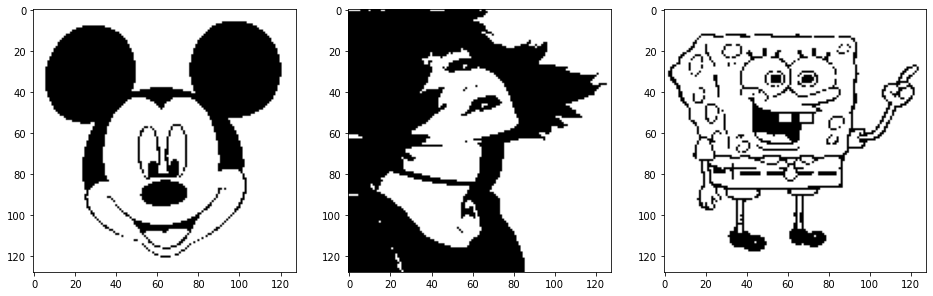

In [29]:
show_pattern(data)

Let's add or learn some patterns. Further, we can also visualize the weights. 

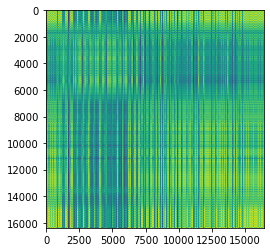

In [30]:
w=add_pattern(w,data[0]) # first image the micky mouse head.
w=add_pattern(w,data[1]) #the girl
w=add_pattern(w,data[2]) # SpongeBobbbbbbbbbbbbbbbbbbbbbbbbbbbbbb
plt.imshow(w)

So far, we have learned some patterns. Now in order to test if that works properly, we need to create some noisy images. We will do that by occluding some parts of the images. we also add gaussian noise to 100 random pixels all over the images

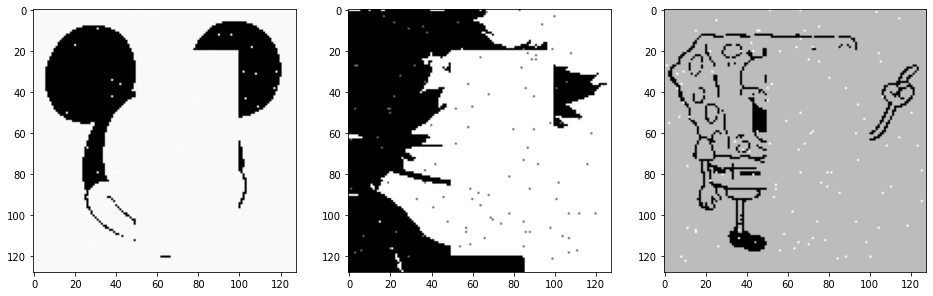

In [31]:
noisy_img=data
for i,d in enumerate(data):
    d[20:120,50:100]=-1
    d[np.random.randint(0,127,100),np.random.randint(0,127,100)]=-(1+np.random.randn())
    noisy_img[i]=d

show_pattern(noisy_img)

So we have our noisy images and from that we will try to recover the original image.

Total iterations: 9
Total iterations: 8
Total iterations: 8


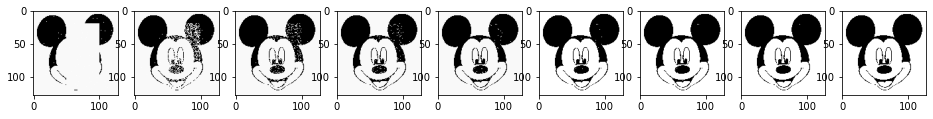

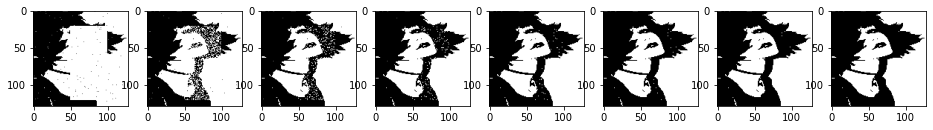

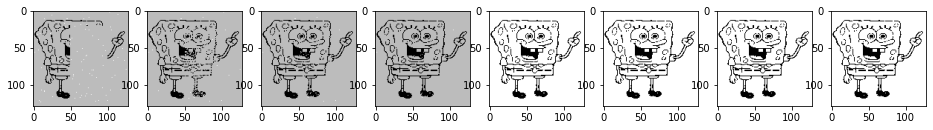

In [32]:
en0,ev0=evolve(w,noisy_img[0])
en1,ev1=evolve(w,noisy_img[1])
en2,ev2=evolve(w,noisy_img[2])
show_pattern(ev0)
show_pattern(ev1)
show_pattern(ev2)


Let's also look at the energy for each evolution for the first pattern (Mickey mouse). The energy keeps decreasing until there is no room to improve further or reach a stable configuration (Local minima). The same trend goes for the other patterns.

Text(0, 0.5, 'Energy')

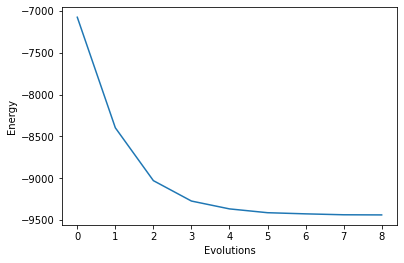

In [33]:
plt.plot(en0)
plt.xlabel("Evolutions")
plt.ylabel("Energy")